In [40]:
# Imports
import numpy as np
from ExoCTK.lightcurve_fitting.lightcurve import LightCurve
from ExoCTK.lightcurve_fitting.parameters import Parameters
from ExoCTK.lightcurve_fitting.models import CustomModel, LinearModel
%matplotlib inline

In [41]:
# Set orbital params
time = np.arange(100)
flux = np.random.normal([0.9 if 25<i<75 else 1 for i in range(100)], scale=0.01)
unc = np.random.normal(size=100, scale=0.01)
params = Parameters(a=20, ecc=0.1, inc=89, limb_dark='quadratic')

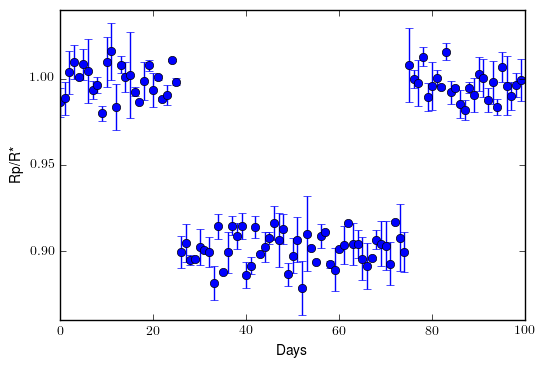

In [42]:
# Instantiate a lightcurve
lc = LightCurve(time, flux, unc, params)
lc.plot()

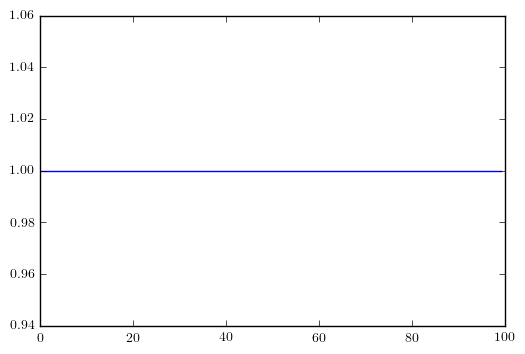

In [43]:
# Create a model
model = LinearModel('linear')
model.plot()

In [ ]:
# Fit the model to the data
lc.fit(model)